In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from betavae import BVAE
import supervised_bvae

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from sklearn.model_selection import train_test_split

In [117]:
# you may wish to modify these first three values if ablating
# beta is as in beta-vae
# alpha is the weight for reconstructing the latent supervision vs. the original image
# (so higher alpha -> more weight on reconstructing the USE embedding or whatever)

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1

In [118]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [120]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,heptagon,almost black,0.027451,0.050980,0.050980,1.481863,1.445323,0.000000,0.000000,30.873125,-4.386932,NaN,False
1,rectangle,mustard brown,0.674510,0.494118,0.015686,0.687809,0.687809,129.534566,-24.544234,0.000000,0.000000,*,False
2,pentagon,cool blue,0.286275,0.517647,0.721569,1.000000,1.000000,0.000000,0.000000,0.000000,-0.578535,NaN,False
3,triangle,olive green,0.403922,0.478431,0.015686,0.908967,0.908967,101.475968,0.000000,0.000000,0.000000,NaN,True
4,ellipse,brownish yellow,0.788235,0.690196,0.011765,0.743424,0.692907,298.500376,0.000000,4.407094,16.628985,NaN,False


In [121]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

In [122]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [123]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#use_model = hub.load(module_url)
import clip
clip_model, preprocess = clip.load("ViT-B/32")
clip_model.eval()



def encode_USE(input_DF):
    return torch.tensor(use_model(input_DF.color.values).numpy())

def encode_CLIP(input_DF):
    tokens = clip.tokenize(input_DF.color.values)
    to_return = torch.empty(size=(0,512))
    for token in tqdm(tokens):
        new_val = clip_model.encode_text(token[None,:]).detach()
        to_return = torch.cat((to_return, new_val / new_val.norm()), dim=0)
    return to_return

# flags

language_supervision = False
encoder = encode_CLIP



train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)

if not language_supervision:
    print('creating direct supervision')
    train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
    valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()
else:
    print('creating language embedding supervision')
    train_meta = encoder(train_meta)
    valid_meta = encoder(valid_meta)


creating direct supervision


In [124]:
supervised_dim = train_meta.shape[1]
supervised_dim

3

In [125]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

def supervised_vae_loss(x, yhat, supervision, mu, var, recon, beta, alpha):
    a = mse_loss(yhat, supervision)
    return a, vae_loss(x, mu, var, recon, beta) + a*alpha

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx], self.latent_supervision[idx]

Epoch 1, Experiment nolang: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:30<00:00,  9.76it/s]

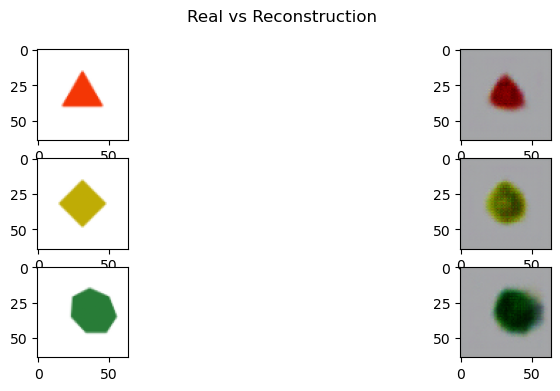

Experiment nolang, Epoch 1 | train loss 6993.24 | valid loss 6092.86 | supervision loss 17.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.58it/s]
Epoch 2, Experiment nolang:  56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 158/282 [00:17<00:13,  9.29it/s]

In [ ]:
# only run this cell if you have to

from torch.utils.data import DataLoader

def run_train(z_dim, beta, alpha, exp_title=''):
    net = supervised_bvae.SupervisedBVAE(z_dim, supervised_out=supervised_dim)
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=False)

    num_batches = len(train_dataloader)
    num_valid_batches = len(valid_dataloader)


    train_losses, valid_losses = [], []
    train_supervision_losses = []

    update_idxs = set([i * (num_batches // updates_per_epoch)
        for i in range(1, updates_per_epoch)] + [num_batches])

    best_valid = 1e9
    for epoch in range(1, 1+num_epochs):
        total_loss = 0.0 
        total_supervision_loss = 0.0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}, Experiment {exp_title}", leave=True, total=num_batches)
        optimizer.zero_grad()
        for idx, batch in enumerate(pbar, start=1):
            x, latent_supervision = batch
            x = x.to(device) # how inefficient is it to stream batches to the device like this? I guess it saves GPU memory

            recon, mu, var, _, yhat = net(x)

            supervision_loss, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)

            total_loss += loss.item() / gradient_accumulation_steps
            total_supervision_loss += supervision_loss.item() / gradient_accumulation_steps
            loss = loss / gradient_accumulation_steps
            loss.backward()


            if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
                optimizer.step()
                optimizer.zero_grad()

            if idx in update_idxs:
                avg_valid_loss = 0.0

                displays = []
                net.eval()
                with torch.no_grad():
                    for batch in valid_dataloader:
                        x, latent_supervision = batch
                        recon, mu, var, z, yhat = net(x)
                        _, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)
                        avg_valid_loss += loss.item() / num_valid_batches
                        if not displays:
                            net.random_z = tuple(z[0].detach().cpu().numpy())
                            displays = [
                                (x[0].permute(1, 2, 0).cpu().numpy(), recon[0].permute(1, 2, 0).cpu().numpy()), 
                                (x[1].permute(1, 2, 0).cpu().numpy(), recon[1].permute(1, 2, 0).cpu().numpy()),
                                (x[2].permute(1, 2, 0).cpu().numpy(), recon[2].permute(1, 2, 0).cpu().numpy())
                            ]

                    if avg_valid_loss < best_valid:
                        torch.save(net, f'models/{beta}-supbvae-{z_dim}dim-{alpha}alpha-nolang')
                        best_valid = avg_valid_loss

                    valid_losses.append(avg_valid_loss)

                    if idx == num_batches:
                        fig, axes = plt.subplots(3, 2)
                        fig.suptitle('Real vs Reconstruction')
                        fig.set_size_inches(10, 4)
                        for (ax1, ax2), (im1, im2) in zip(axes, displays):
                            ax1.imshow(im1)
                            ax2.imshow(im2)
                        plt.show()
                net.train()


                pbar.set_description(f"Experiment {exp_title}, Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                    f" | valid loss {avg_valid_loss:.2f}" + f' | supervision loss {total_supervision_loss / idx:.2f}')
                train_losses.append(total_loss / idx) 
                train_supervision_losses.append(total_supervision_loss / idx)



z_dims = [8, 16, 64]
betas = [0.5, 1, 2.5]
alphas = [0.1, 0.5, 1, 2.5]
run_train(16, 2.5, 1, exp_title='nolang')
#for idx, (z_dim, beta, alpha) in enumerate(itertools.product(z_dims, betas, alphas)):
#    run_train(z_dim, beta, alpha, exp_title=str(idx))

In [11]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

#print(use_model('asdf'))
#plt.plot(train_losses, label='Train Loss')
#plt.plot(valid_losses, label='Valid Loss')
#plt.plot(train_supervision_losses, label='Train Supervision Loss')
#plt.legend()
#plt.savefig('trainplot.png')

tensor([0.0251+0.j, 0.0264+0.j, 0.0029+0.j, 0.0013+0.j, 0.0009+0.j, 0.0008+0.j, 0.0007+0.j,
        0.0002+0.j, 0.0002+0.j, 0.0003+0.j, 0.0003+0.j, 0.0004+0.j, 0.0005+0.j, 0.0005+0.j,
        0.0004+0.j, 0.0004+0.j])
tensor([0.0351+0.j, 0.0364+0.j, 0.0129+0.j, 0.0113+0.j, 0.0109+0.j, 0.0108+0.j, 0.0107+0.j,
        0.0102+0.j, 0.0102+0.j, 0.0103+0.j, 0.0103+0.j, 0.0105+0.j, 0.0105+0.j, 0.0104+0.j,
        0.0104+0.j, 0.0104+0.j])
unpert tensor(3.8231)
tensor(3.5116)
tensor(11.4945)
unpert tensor(3.7640)
tensor(3.4945)
tensor(6.2514)
unpert tensor(4.1072)
tensor(3.9707)
tensor(10.6405)
unpert tensor(4.2283)
tensor(3.8580)
tensor(8.7778)
unpert tensor(3.4514)
tensor(3.5034)
tensor(10.3244)
0.4352416
1.0


<Figure size 640x480 with 0 Axes>

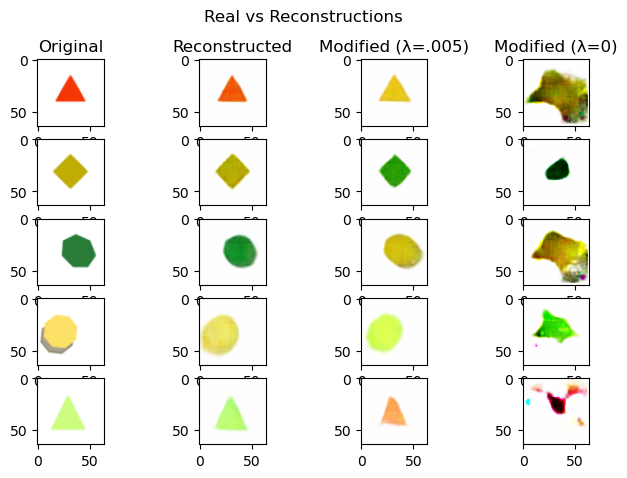

In [59]:
import importlib
importlib.reload(supervised_bvae)

model = torch.load('models/2.5-supbvae-16dim-1alpha-nolang')
W = model.z_to_out_map.weight.detach()
print(torch.linalg.eig(W.transpose(0, 1) @ W).eigenvalues)
print(torch.linalg.eig(W.transpose(0, 1) @ W + 0.01*torch.eye(16)).eigenvalues)
model.eval()
valid_dataset = DatasetWrapper(valid, valid_meta)
displays = []
ys = []
residuals = []

n_examples = 5

with torch.no_grad():
    for sample_idx in range(5):
        x, latent_supervision = valid_dataset[sample_idx]
        x = x[None,:]
        _, next_latent_supervision = valid_dataset[(sample_idx+1) % n_examples]
        recon, mu, var, z, yhat = model(x)
        print('unpert', z.norm())
        
        ys += [torch.norm(latent_supervision)]
        residuals += [torch.norm(latent_supervision - yhat)]
        
        recon2 = model.forward_with_supervision(x, next_latent_supervision, smoothing=0.005)
        recon3 = model.forward_with_supervision(x, next_latent_supervision, smoothing=0)
        
        
        displays += [[x[0].permute(1, 2, 0).cpu().numpy(),
                       recon[0].permute(1, 2, 0).cpu().numpy(), recon2[0].permute(1, 2, 0).cpu().numpy(),
                       recon3[0].permute(1, 2, 0).cpu().numpy()]]
print(np.mean(residuals))
print(np.mean(ys))


fig, axes = plt.subplots(n_examples, 4)
fig.suptitle('Real vs Reconstructions')
fig.set_size_inches(8, n_examples)
for (ax1, ax2, ax3, ax4), (im1, im2, im3, im4) in zip(axes, displays):
    ax1.imshow(im1)
    ax2.imshow(im2)
    ax3.imshow(im3)
    ax4.imshow(im4)

cols = ['Original', 'Reconstructed', 'Modified (λ=.005)', 'Modified (λ=0)']
for ax, col in zip(axes[0], cols):
    ax.set_title(col, rotation=0, size='large')
plt.show()
plt.savefig('asdf.png')

tensor(7.6381, grad_fn=<NormBackward1>)
tensor(7.6380, grad_fn=<NormBackward1>)
tensor(7.6380, grad_fn=<NormBackward1>)
tensor(7.6381, grad_fn=<NormBackward1>)


<Figure size 640x480 with 0 Axes>

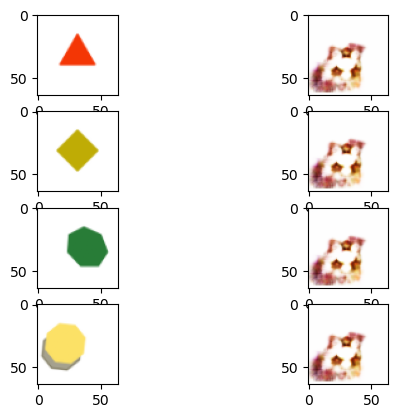

In [115]:
# this cell only works if you did CLIP model

alt_text_supervision = ['amongus']
plt.clf()
fig, axes = plt.subplots(4, 2)
for i in range(4):
    
    x, latent_supervision = valid_dataset[i]
    supervision = clip_model.encode_text(clip.tokenize(alt_text_supervision)).detach()[0]
    supervision = supervision / supervision.norm()
    recon = model.forward_with_supervision(x[None], supervision, smoothing=0)
    axes[i,0].imshow(x.permute(1, 2, 0).cpu().numpy())
    axes[i,1].imshow(recon[0].permute(1,2,0).detach().cpu().numpy())
plt.show()